# Phase 2b: Feature Engineering & Impact Analysis

In this notebook, we apply the custom feature engineering pipeline and analyze how the new features correlate with customer churn.

### 1. Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.data_preprocessing import load_data, clean_data
from src.feature_engineering import apply_feature_engineering

# Load and clean data (using the functions from previous step)
df_raw = load_data('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_clean = clean_data(df_raw)

# Apply Feature Engineering
df_eng = apply_feature_engineering(df_clean)

print(f"Original shape: {df_clean.shape}")
print(f"Shape after Feature Engineering: {df_eng.shape}")
display(df_eng.head(3))

Loading data from c:\Users\ishfa\datascience\customer-churn-prediction\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv...
Removed 22 duplicate rows.
Original shape: (7021, 20)
Shape after Feature Engineering: (7021, 31)


c:\Users\ishfa\datascience\customer-churn-prediction\src\data_preprocessing.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,IsNewCustomer,TotalServices,HasDualPlay,HasStreamingBundle,HasSecurityBundle,AvgMonthlySpend,PriceHikeRatio,IsAutoPayment,Contract_Payment,Senior_Internet
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,1,1,0,0,0,29.850000,1.000000,0,Month-to-month_Electronic check,0_DSL
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0,3,1,0,0,55.573529,1.024768,0,One year_Mailed check,0_DSL
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,1,3,1,0,0,54.075000,0.995839,0,Month-to-month_Mailed check,0_DSL


### 2. Impact Analysis: Tenure Features
We expect new customers to be high risk. Let's verify our `TenureGroup` binning.

C:\Users\ishfa\AppData\Local\Temp\ipykernel_25596\728448672.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df_eng.groupby('TenureGroup')['Churn'].apply(lambda x: (x=='Yes').mean()).reset_index()
C:\Users\ishfa\AppData\Local\Temp\ipykernel_25596\728448672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TenureGroup', y='Churn', data=churn_by_tenure, palette='Blues_d')


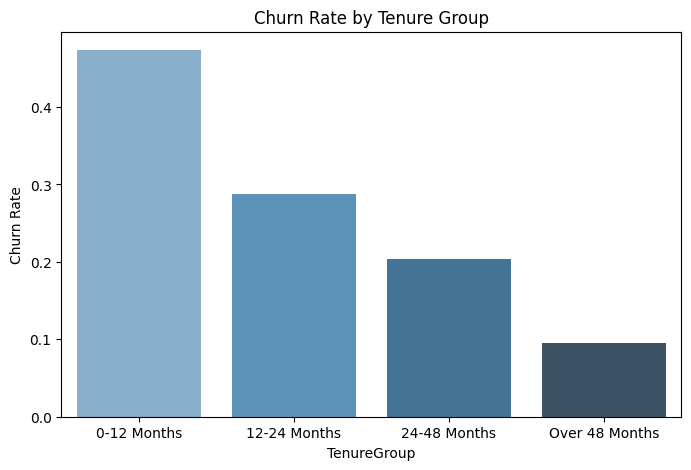

Insight: Churn drops drastically after the first year.


In [2]:
# Calculate Churn Rate by Tenure Group
churn_by_tenure = df_eng.groupby('TenureGroup')['Churn'].apply(lambda x: (x=='Yes').mean()).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='TenureGroup', y='Churn', data=churn_by_tenure, palette='Blues_d')
plt.title('Churn Rate by Tenure Group')
plt.ylabel('Churn Rate')
plt.show()

print("Insight: Churn drops drastically after the first year.")

### 3. Impact Analysis: Service Bundles
Does having more services make a customer 'stickier'? We check `TotalServices`.

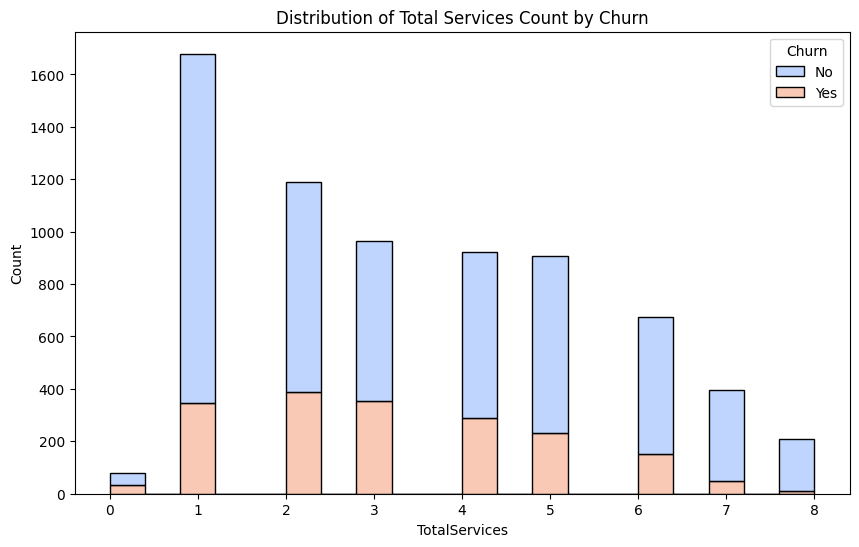

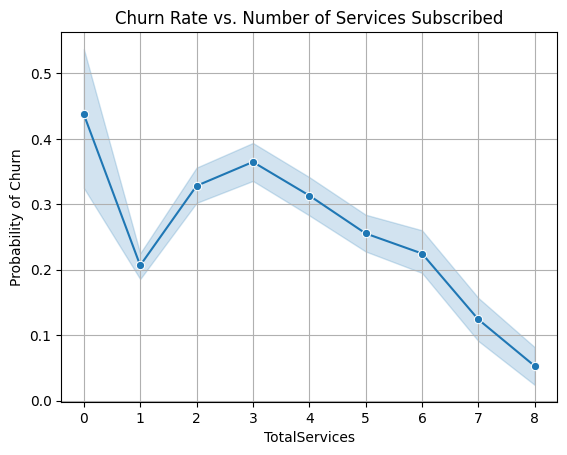

Insight: Customers with 1 service churn often. Those with 4+ rarely churn.


In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_eng, x='TotalServices', hue='Churn', multiple='stack', palette='coolwarm')
plt.title('Distribution of Total Services Count by Churn')
plt.show()

# Visualize Churn Rate vs Total Services
sns.lineplot(data=df_eng, x='TotalServices', y=df_eng['Churn'].apply(lambda x: 1 if x=='Yes' else 0), marker='o')
plt.title('Churn Rate vs. Number of Services Subscribed')
plt.ylabel('Probability of Churn')
plt.grid(True)
plt.show()

print("Insight: Customers with 1 service churn often. Those with 4+ rarely churn.")

### 4. Impact Analysis: Financial Features
We analyze `PriceHikeRatio`. If this ratio is > 1, it means the customer is paying more now than their historical average.

C:\Users\ishfa\AppData\Local\Temp\ipykernel_25596\971011552.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='PriceHikeRatio', data=df_eng, showfliers=False, palette='Set2')


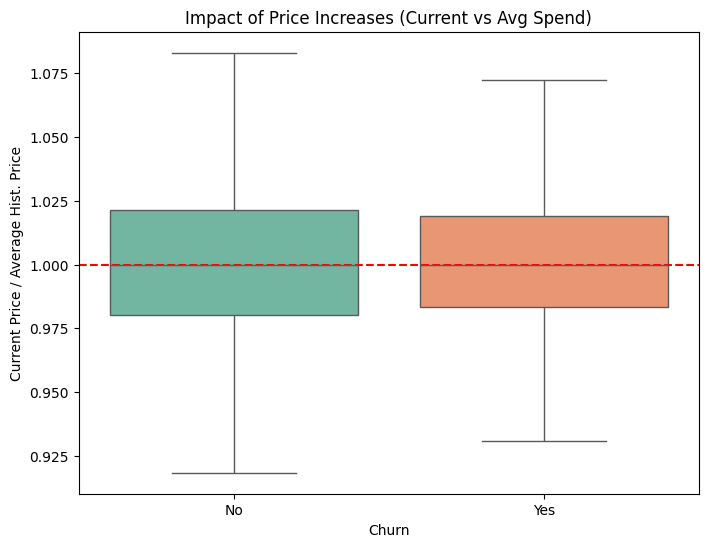

Insight: Churners often have a ratio > 1, indicating recent price increases might drive attrition.


In [4]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='PriceHikeRatio', data=df_eng, showfliers=False, palette='Set2')
plt.title('Impact of Price Increases (Current vs Avg Spend)')
plt.ylabel('Current Price / Average Hist. Price')
plt.axhline(1.0, color='red', linestyle='--')
plt.show()

print("Insight: Churners often have a ratio > 1, indicating recent price increases might drive attrition.")

### 5. Impact Analysis: Interactions
Visualizing the combined risk of Contract and Payment Method.

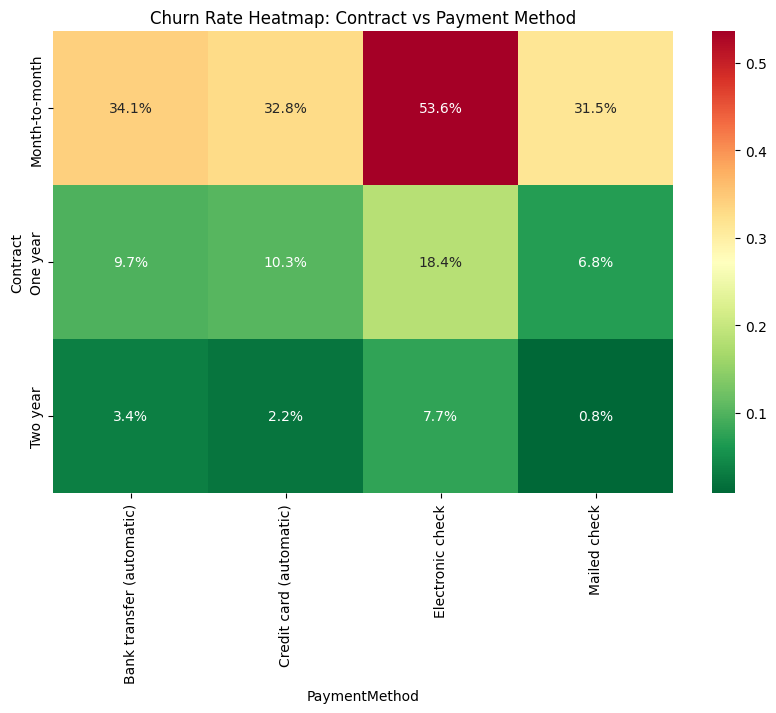

In [5]:
# Pivot table for heatmap
pivot = df_eng.pivot_table(index='Contract', columns='PaymentMethod', 
                           values='Churn', aggfunc=lambda x: (x=='Yes').mean())

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.1%', cmap='RdYlGn_r')
plt.title('Churn Rate Heatmap: Contract vs Payment Method')
plt.show()